In [ ]:
# for unzipping the zip file run this
#!unzip '/content/drive/MyDrive/Deepfake/deepfake.zip' -d "/content/drive/MyDrive/Deepfake/"

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Building a deepfake image detection model which is capable of classifying image into two categories Ai-Genrated or Real image using TensorFlow

# Problem Definition
* The model is used for detection of deepfake or Ai-generated images that
  are now widly used for spreading hate speech and fake news.

# Data
* We are using Kaggle data  uploaded on the drive and will also upload     zip file on github  <i>refer https://github.com/vrmaverick/DeepFake_Detector </i>

# Evaluation

* Prediction Probalities should be more than 90% which is this projects goal to acheive

# Features

* Few key information abot features as the project is based on image classification which are unstructured, Thus there is no such distinctive feature but the data is divide into 3 parts . Testing,Training and Validation. and the model will be a binary classifier

In [49]:
# Importing all required tools
import tensorflow as tf
import tensorflow_hub as hub

# For Data Structuring
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# File Handling
import os

In [50]:
print("TF Version",tf.__version__)
print("TF hub version :",hub.__version__)

TF Version 2.15.0
TF hub version : 0.16.0


# Checking for GPU accessibility
Can change runtime type if needed on  google collab


In [51]:
print("GPU available"if tf.config.list_physical_devices("GPU")else "Not Available")

GPU available


# Defining all the Functions that are used in the notebook further

In [68]:
# Generating file paths for images
def paths(p):
  # Specify the folder path within your Google Drive
  folder_path = p
  # List files in the folder
  file_paths = []
  file_name = []
  for root, dirs, files in os.walk(folder_path):
      for file in files:
          file_paths.append(os.path.join(root, file))
          file_name.append(file)
          # print(f"File Path: {os.path.join(root, file)}")
  return file_paths,file_name


# Getting our data ready

*Turning our images to tensors or numerical format*

To check if image exists on that path run the cell below else one may skip it

In [ ]:
# !ls '/content/drive/MyDrive/Deepfake/Ai vs Real image Detection Dataset/train/FAKE/1069 (10).jpg'

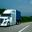

In [6]:
# Can be used for displaying images
from IPython.display import Image
Image('/content/drive/MyDrive/Deepfake/Ai vs Real image Detection Dataset/train/FAKE/1069 (10).jpg')

# Getting image paths and labels

In [69]:
# Accessing File paths of Ai Generated images which will be used for training
file_paths,file_name = paths('/content/drive/MyDrive/Deepfake/Ai vs Real image Detection Dataset/train/FAKE')

In [54]:
len(file_paths)

37800

In [55]:
len(file_name)

37800

In [56]:
# Creating a DataFrame for Convinience
df = pd.DataFrame(file_name, columns=['Image'])
df['Path']= file_paths
df['Class']='Fake'
df.head()

,Image,Path,Class
0,5811 (5).jpg,/content/drive/MyDrive/Deepfake/Ai vs Real ima...,Fake
1,5882.jpg,/content/drive/MyDrive/Deepfake/Ai vs Real ima...,Fake
2,5810 (7).jpg,/content/drive/MyDrive/Deepfake/Ai vs Real ima...,Fake
3,5856 (2).jpg,/content/drive/MyDrive/Deepfake/Ai vs Real ima...,Fake
4,5946 (7).jpg,/content/drive/MyDrive/Deepfake/Ai vs Real ima...,Fake


In [70]:
# Accessing File paths of Real images which will be used for training
file_paths,file_name = paths('/content/drive/MyDrive/Deepfake/Ai vs Real image Detection Dataset/test/REAL')


In [58]:
print(len(file_name))
new_data = pd.DataFrame(file_name, columns=['Image'])
new_data['Path'] = file_paths
new_data['Class'] = 'Real'
resulting_data = pd.concat([df, new_data], ignore_index=True)
del new_data
resulting_data

10000


,Image,Path,Class
0,5811 (5).jpg,/content/drive/MyDrive/Deepfake/Ai vs Real ima...,Fake
1,5882.jpg,/content/drive/MyDrive/Deepfake/Ai vs Real ima...,Fake
2,5810 (7).jpg,/content/drive/MyDrive/Deepfake/Ai vs Real ima...,Fake
3,5856 (2).jpg,/content/drive/MyDrive/Deepfake/Ai vs Real ima...,Fake
4,5946 (7).jpg,/content/drive/MyDrive/Deepfake/Ai vs Real ima...,Fake
...,...,...,...
47795,0134 (8).jpg,/content/drive/MyDrive/Deepfake/Ai vs Real ima...,Real
47796,0049 (6).jpg,/content/drive/MyDrive/Deepfake/Ai vs Real ima...,Real
47797,0103 (8).jpg,/content/drive/MyDrive/Deepfake/Ai vs Real ima...,Real
47798,0055 (8).jpg,/content/drive/MyDrive/Deepfake/Ai vs Real ima...,Real


In [59]:

resulting_data['Class'].value_counts()

Fake    37800
Real    10000
Name: Class, dtype: int64

In [60]:
resulting_data.to_csv('//content/drive/MyDrive/Deepfake/Test_Info.csv', index=False)

# Categorigal labels to tensors

In [61]:
labels = resulting_data['Class'].to_numpy()

In [62]:
labels

array(['Fake', 'Fake', 'Fake', ..., 'Real', 'Real', 'Real'], dtype=object)

In [63]:
# len(labels)
unique = np.unique(labels)

Turning Labels into boolean or numeric form

In [64]:
bool_labels = [label == unique for label in labels]
bool_labels[:10]

[array([ True, False]),
 array([ True, False]),
 array([ True, False]),
 array([ True, False]),
 array([ True, False]),
 array([ True, False]),
 array([ True, False]),
 array([ True, False]),
 array([ True, False]),
 array([ True, False])]

In [65]:
len(bool_labels) #just for verification

47800

In [66]:
# Converting bool to Tensors
print(labels[1])
print(bool_labels[1].astype(int)) # as we have only two classes


Fake
[1 0]


# To reduce Time between Expirimentation we will take help of sampling 1000 images first to get good idea of the parameters

So we will start with 1000 images

In [67]:
# Number of images for expirimenting
NUM_IMAGES = 1000 #@param {type:"slider",min:1000,max:47000}

# Modelling